## Credit default dataset analysis

The analysis of the dataset is presented in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble  import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
import time
from xgboost import XGBClassifier
import xgboost as xgb

/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [3]:
raw_data = pd.read_csv("CreditTraining.csv", quotechar='"', decimal=",")
raw_data.head()

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,07/08/1977,13/02/2012,NP_Client,University,Married,3.0,1,36.0,1.0,C,14/02/2012,Sales,Owned,1,NaN,B
1,573,0,Existing Client,13/06/1974,04/02/2009,P_Client,University,Married,0.0,12,18.0,2.0,C,30/06/2011,Sales,Parents,1,NaN,G
2,9194,0,Non Existing Client,07/11/1973,03/04/2012,NP_Client,University,Married,2.0,10,36.0,1.0,C,04/04/2012,Sales,Owned,1,NaN,B
3,3016,1,Existing Client,08/07/1982,25/08/2011,NP_Client,University,Married,3.0,3,36.0,1.0,C,07/09/2011,Sales,New rent,1,31/12/2012,L
4,6524,0,Non Existing Client,18/08/1953,10/01/2012,NP_Client,University,Married,2.0,1,36.0,1.0,C,11/01/2012,Sales,Owned,1,NaN,D


### Data Preprocessing

In [4]:
# Set Id_Customer as index
raw_data = raw_data.set_index('Id_Customer')

In [5]:
# Dates are converted to python datetime
raw_data['BirthDate'] = pd.to_datetime(raw_data['BirthDate'])
raw_data['Customer_Open_Date'] = pd.to_datetime(raw_data['Customer_Open_Date'])
raw_data['Prod_Decision_Date'] = pd.to_datetime(raw_data['Prod_Decision_Date'])
raw_data['Prod_Closed_Date'] = pd.to_datetime(raw_data['Prod_Closed_Date'])

In [6]:
# As the age is more relevant for the interpretation we create the age column
def convert_birthday_to_age(x):
    return 2020 - x.year
raw_data["age"] = raw_data["BirthDate"].apply(convert_birthday_to_age)

In [7]:
raw_data

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,age
Id_Customer,,,,,,,,,,,,,,,,,,,
7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36.000,1.0,C,2012-02-14,Sales,Owned,1,NaT,B,43
573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18.000,2.0,C,2011-06-30,Sales,Parents,1,NaT,G,46
9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36.000,1.0,C,2012-04-04,Sales,Owned,1,NaT,B,47
3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36.000,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L,38
6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36.000,1.0,C,2012-11-01,Sales,Owned,1,NaT,D,67
3858,0,Existing Client,1983-04-03,2011-09-15,NP_Client,University,Married,0.0,28,60.000,2.0,C,2011-04-10,Sales,Old rent,1,NaT,C,37
2189,0,Non Existing Client,1979-09-25,2011-07-17,NP_Client,University,Married,0.0,10,36.000,1.0,C,2011-07-28,Sales,Owned,1,NaT,B,41
9338,0,Non Existing Client,1953-04-10,2012-11-04,NP_Client,University,Married,0.0,15,36.000,1.0,C,2012-12-04,Sales,Owned,1,2013-04-16,B,67
9578,0,Existing Client,1974-01-03,2001-02-20,NP_Client,University,Single,0.0,0,500.000,3.0,P,2012-02-04,Branch,Owned,1,NaT,E,46


### Variables analysis
Let's plot and analyse some of the main variables of the dataset. This should help us select the relevant variables for our classifier and analyze its predictions.

##### Credit default

Number of customers: 5380
Number of credit default: 393
Credit default rate in the dataset: 7.304832713754647%


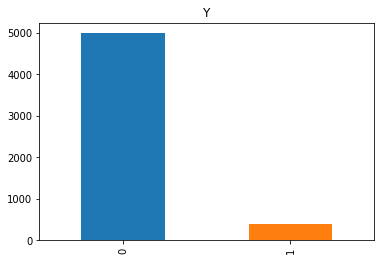

In [8]:
raw_data["Y"].value_counts().plot(kind='bar', title="Y")
nb_of_customer = len(raw_data['Y'])
nb_of_credit_default = len(raw_data[raw_data['Y'] == 1])
credit_default_rate = nb_of_credit_default / nb_of_customer * 100
print(f"Number of customers: {nb_of_customer}")
print(f"Number of credit default: {nb_of_credit_default}")
print(f"Credit default rate in the dataset: {credit_default_rate}%")

The dataset is **highly unbalanced**, only 7% of the examples are positive. This means that the classifier systematically predicting 0 has an accuracy of almost 93%. Accuracy is therefore not the key indicator for this problem. It seems consistent to consider that an organization analyzing these data wants to avoid lending to a consumer who will default, i.e. here get the highest **recall**. However, we have no further indication of this and it could also be that precision is important, so we will use for the **F1 score** to evaluate our models without neglecting the comments on recall and precision obtained. 

Moreover we will have to rebalance our dataset thanks to sampling methods at training time.

##### Education

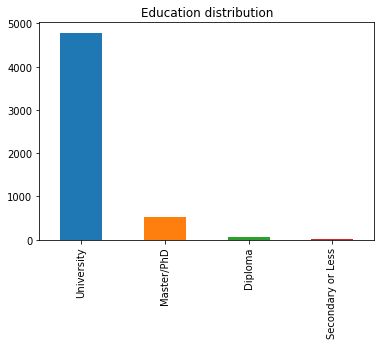

In [9]:
# Education distribution
raw_data['Educational_Level'].value_counts().plot(kind='bar', title="Education distribution")

Very little information is given on education, the **vast majority** of consumers are in the University category.

##### Age 

[Text(0, 0, 'default'), Text(0, 0, 'no default')]

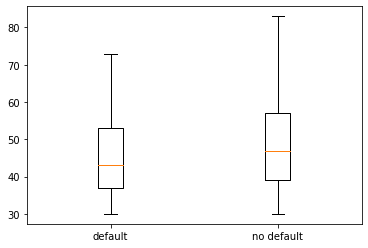

In [10]:
age_dict = {'default': raw_data[raw_data['Y'] == 1]['age'], 'no default': raw_data[raw_data['Y'] == 0]['age']}
fig, ax = plt.subplots()
ax.boxplot(age_dict.values())
ax.set_xticklabels(age_dict.keys())

As expected those who default are a little **younger** than those who don't.

##### Net Annual Income

In [11]:
df_income =raw_data.groupby(["Y"]).agg({"Net_Annual_Income":{"min","median","max", "mean"}} )
df_income

Net_Annual_Income                           
                min       mean median      max
Y                                             
0             0.004  62.921695   36.0  10000.0
1             0.060  39.110687   36.0    576.0

People with disabilities have a lower average income, however, this identical median is quite surprising.

In [12]:
raw_data["Net_Annual_Income"].describe()

count     5378.000000
mean        61.181694
std        237.744827
min          0.004000
25%         20.000000
50%         36.000000
75%         36.000000
max      10000.000000
Name: Net_Annual_Income, dtype: float64

In [13]:
print(len(raw_data[raw_data["Net_Annual_Income"] == 36.0]))

1807


This 36.0 corresponds to the median value of the dataset, more than a third of the lines have this value for income. The original dataset must have had **a significant proportion of missing data**, which were filled in with the median value. This is unfortunate and will not allow us to attempt to use finer methods to infer these missing data.

We continue this analysis on notebook R **credit_prediction.pdf**. We perform a **PCA** and **MCA** analysis in order to better understand the link between the different variables and to be able to select them correctly.

### Data Transformation

Let's process the data for a classifier. 

We select the variables that we think are relevant based on the previous analyses performed. Categorical variables are **binary encoded** when they have only 2 classes and in **one hot encoding** otherwise, except for education for which we have chosen to establish an order relation. Finally the number of lines containing missing data being marginal, we took the decision to delete those lines.

In [14]:
# Quantitative data
transformed_data = pd.concat([
    raw_data["Y"], 
    raw_data["age"], 
    raw_data["Net_Annual_Income"], 
    raw_data["Years_At_Business"], 
    raw_data["Years_At_Residence"],
    raw_data["Nb_Of_Products"],
    raw_data["Number_Of_Dependant"],
], axis=1, keys=['Y',
                'age',
                'Net_Annual_Income',
                'Years_At_Business',
                'Years_At_Residence',
                'Nb_Of_Products',
                'Number_Of_Dependant',
])

In [15]:
# One hot encoding
one_hot_marital_status = pd.get_dummies(raw_data["Marital_Status"])
transformed_data = transformed_data.join(one_hot_marital_status)
one_hot_prod_sub_category = pd.get_dummies(raw_data["Prod_Sub_Category"])
transformed_data = transformed_data.join(one_hot_prod_sub_category)
one_hot_type_of_residence = pd.get_dummies(raw_data["Type_Of_Residence"])
transformed_data = transformed_data.join(one_hot_type_of_residence)

In [16]:
# We take the liberty of establishing an order relationship in the diplomas 
# to consider education as a quantitative variable.

switch = {
        'Secondary or Less': 0,
        "Diploma": 1,
        "University": 2,
        "Master/PhD": 3
    }

def quantify_eductation(x):
    if not switch.get(x):
        return 0
    return switch.get(x)

transformed_data["education"] = raw_data["Educational_Level"].apply(quantify_eductation)

In [17]:
# Binary encoding
le_ct = preprocessing.LabelEncoder()
le_ct.fit(raw_data['Customer_Type'])

def label_customer_type(x):
    return le_ct.transform([x])[0]

le_s = preprocessing.LabelEncoder()
le_s.fit(raw_data['Source'])

def label_source(x):
    return le_s.transform([x])[0]

le_pc = preprocessing.LabelEncoder()
le_pc.fit(raw_data['P_Client'])

def label_p_client(x):
    return le_pc.transform([x])[0]

transformed_data['Customer_Type'] = raw_data['Customer_Type'].apply(label_customer_type)
transformed_data['Source'] = raw_data['Source'].apply(label_source)
transformed_data['P_Client'] = raw_data['P_Client'].apply(label_p_client)

In [18]:
# Prod_Decision_Date and Prod_Decision_Date are transformed in ages
raw_data['Age_Decision']=(raw_data['Prod_Decision_Date'].dropna()-raw_data[~raw_data['Prod_Decision_Date'].isna()]['BirthDate']).dt.days
raw_data['Seniority_Decision']=(raw_data['Prod_Decision_Date'].dropna()-raw_data[~raw_data['Prod_Decision_Date'].isna()]['Customer_Open_Date']).dt.days
transformed_data['Age_Decision'] = raw_data['Age_Decision']
transformed_data['Seniority_Decision'] = raw_data['Seniority_Decision']

In [19]:
# The dates of closures being all very close to each other, 
# we made the choice to keep only the information of the presence of such a date or not.
transformed_data['Closed']=(~raw_data['Prod_Closed_Date'].isna())*1

In [20]:
# Only 4 lines had missing values at this stage
transformed_data[transformed_data.isnull().values].index

Int64Index([8953, 9399, 398, 5882, 9588, 9555], dtype='int64', name='Id_Customer')

In [21]:
# We remove then
transformed_data = transformed_data.drop(transformed_data[transformed_data.isnull().values].index)

### Train / Test split

As the test dataset is not provided we will separate our dataset and set a test set to evaluate the performance of our classifiers. T**he test set will no longer be used** before the evaluation of the chosen classifier(s).

In [22]:
X_df = transformed_data.loc[:, transformed_data.columns != 'Y']
y_df = transformed_data.loc[:,'Y']
X = X_df.values
y = y_df.values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)

### Pipeline

We have built a small pipeline for rapid evaluation of classifiers and sampling methods. It returns the f1 score, the recall, the precision and the accuracy obtained by a **k-fold validation** (k can of course be chosen and corresponds to the n_splits parameter). For each split we proceed as follows:
- The training set and the validation set are separated.
- The training set and validation set are **rescaled** thanks to the well known StandardScaler method of sklearn.
- The selected **sampling method** is applied to the training set.
- The model is **trained** on the training set.
- Finally the model is **evaluated** on the validation set.


In [24]:
def pipeline(model, n_splits = 8, sampler = None):
    kf = KFold(n_splits=n_splits)
    val_acc = 0
    val_f1 = 0
    val_recall = 0
    val_precision = 0

    for train, validation in kf.split(X_train):
        X_train_, X_validation_, y_train_, y_validation_ = X_train[train], X_train[validation], y_train[train], y_train[validation]

        scaler = StandardScaler()
        scaler.fit(X_train_)
        X_train_ = scaler.transform(X_train_)
        X_validation_ = scaler.transform(X_validation_)

        if sampler:
            X_train_, y_train_ = sampler.fit_resample(X_train_, y_train_)

        clf = model.fit(X_train_, y_train_)

        y_predict = clf.predict(X_validation_)

        val_f1 += f1_score(y_validation_, y_predict)
        val_acc += accuracy_score(y_validation_, y_predict)
        val_recall += recall_score(y_validation_, y_predict)
        val_precision += precision_score(y_validation_, y_predict)

    val_f1 /= n_splits
    val_acc /= n_splits
    val_recall /= n_splits
    val_precision /= n_splits

    return {
        "f1": val_f1,
        "recall": val_recall,
        "precision": val_precision,
        "accuracy": val_acc
    }

In [25]:
# pipeline test with LogisticRegression and RandomUnderSampler
n_splits = 3
model = LogisticRegression(random_state=0)
sampler = RandomUnderSampler(random_state=42)

pipeline(model, sampler = sampler, n_splits = n_splits)

{'f1': 0.526011616877493,
 'recall': 0.8811742048087629,
 'precision': 0.37510842223956975,
 'accuracy': 0.8852625920726694}

### Sampler Selection

Compare different sampling method (undersampling and oversampling).

We test the main sampling methods with a simple logistic regression model to start with.

In [26]:
samplers = [
    ('None', None), 
    ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    #  ('CondensedNearestNeighbour', CondensedNearestNeighbour()), 
    ('EditedNearestNeighbours', EditedNearestNeighbours()), 
    ('RepeatedEditedNearestNeighbours', RepeatedEditedNearestNeighbours()), 
    ('AllKNN', AllKNN()),
    ('TomeLinks', TomekLinks()),
    ('Near Miss', NearMiss()),
    ('RandomOverSampler', RandomOverSampler()),
    ('SMOTE', SMOTE()),
    ('SVMSMOTE', SVMSMOTE()),
    ('ADASYN', ADASYN())
]

In [27]:
model = LogisticRegression(random_state=0)
# model = XGBClassifier()

column_names = ["sampler", "f1", "recall", "precision", "accuracy"]
scores = pd.DataFrame(columns = column_names)

for sampler_name, sampler in samplers:
    t1 = time.time()
    print(f"Sampler: {sampler_name}")
    results = pipeline(model, sampler = sampler)
    score_dict = {
        "sampler": sampler_name
    }
    score_dict.update(results)
    scores = scores.append(score_dict, ignore_index=True)
    t2 = time.time()
    print(f"Computation time: {t2 - t1}")
    print()
    
scores

Sampler: None
Computation time: 0.7204267978668213

Sampler: RandomUnderSampler
Computation time: 0.3072388172149658

Sampler: EditedNearestNeighbours
Computation time: 5.7966628074646

Sampler: RepeatedEditedNearestNeighbours
Computation time: 17.79119300842285

Sampler: AllKNN
Computation time: 11.413511753082275

Sampler: TomeLinks
Computation time: 5.30507755279541

Sampler: Near Miss
Computation time: 0.9799644947052002

Sampler: RandomOverSampler
Computation time: 0.6922457218170166

Sampler: SMOTE
Computation time: 0.7875645160675049

Sampler: SVMSMOTE
Computation time: 3.4714601039886475

Sampler: ADASYN
Computation time: 1.5919153690338135



,sampler,f1,recall,precision,accuracy
0,None,0.215903,0.135797,0.548575,0.929058
1,RandomUnderSampler,0.539393,0.887002,0.388327,0.891174
2,EditedNearestNeighbours,0.553373,0.822972,0.418038,0.904533
3,RepeatedEditedNearestNeighbours,0.551812,0.838132,0.412381,0.902343
4,AllKNN,0.553613,0.835243,0.415170,0.903438
5,TomeLinks,0.439443,0.399006,0.497700,0.926869
6,Near Miss,0.175173,0.726868,0.099776,0.506237
7,RandomOverSampler,0.551637,0.876029,0.403475,0.897745
8,SMOTE,0.553904,0.872904,0.406541,0.899059
9,SVMSMOTE,0.554819,0.854740,0.411701,0.901686


We observe here that with the **simplest sampling method** (RandomUnderSampler) the **f1 validation score is multiplied by 2**, this demonstrates the relevance of training on a balanced dataset. From a recall point of view, the change is even more important (multiplied by about 5). Without any rebalancing, the logistic regression detects 2 people out of 10 who will fail, whereas with random undersampling the score rises to almost 9 out of 10.

### Model Selection

Compare different classifier.

Here we use AllKNN as a sampling method, because it gave the best results for logistic regression, but we are not sure if it is the best for the other classifiers, we test it afterwards.

In [28]:
models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('RForest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('MLP', MLPClassifier(max_iter=1000))
]

In [29]:
sampler = AllKNN()

column_names = ["model", "f1", "recall", "precision", "accuracy"]
scores = pd.DataFrame(columns = column_names)

for model_name, model in models:
    t1 = time.time()
    print(f"Model: {model_name}")
    results = pipeline(model, sampler = sampler)
    score_dict = {
        "model": model_name
    }
    score_dict.update(results)
    scores = scores.append(score_dict, ignore_index=True)
    t2 = time.time()
    print(f"Computation time: {t2 - t1}")
    print()
    
scores

Model: LR
Computation time: 12.899928569793701

Model: LDA
Computation time: 11.3678138256073

Model: KNN
Computation time: 11.496993064880371

Model: CART
Computation time: 10.934793472290039

Model: NB
Computation time: 10.690687417984009

Model: SVM
Computation time: 12.171034097671509

Model: RForest
Computation time: 13.209991216659546

Model: AdaBoost
Computation time: 12.038196086883545

Model: MLP
Computation time: 85.61862826347351



,model,f1,recall,precision,accuracy
0,LR,0.553613,0.835243,0.415170,0.903438
1,LDA,0.556546,0.884314,0.407036,0.898840
2,KNN,0.498316,0.628726,0.414151,0.909135
3,CART,0.514679,0.773342,0.387449,0.895336
4,NB,0.154563,0.944508,0.084287,0.255749
5,SVM,0.554211,0.818403,0.419764,0.905629
6,RForest,0.555892,0.772142,0.435950,0.911321
7,AdaBoost,0.546048,0.791882,0.417452,0.905627
8,MLP,0.536849,0.788885,0.407765,0.902343


It is very interesting to note that LDA, SVM and RandomForest give very similar f1 scores, however there are **significant differences in recall and precision**. There is therefore a compromise to be found here depending on the use one wishes to make of these data. An application needing a high recall will prefer the LDA, one wanting more precision the RamdomForest while SVM is a more balanced compromise.

### Combo

In [30]:
models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('XGBClassifier', XGBClassifier())
    # ('KNN', KNeighborsClassifier()),
    # ('CART', DecisionTreeClassifier()),
    # ('NB', GaussianNB()),
    # ('SVM', SVC()),
    # ('RForest', RandomForestClassifier()),
    # ('AdaBoost', AdaBoostClassifier()),
    # ('MLP', MLPClassifier())
]

samplers = [
    ('None', None), 
    ('RandomUnderSampler', RandomUnderSampler(random_state=42)),
    # ('CondensedNearestNeighbour', CondensedNearestNeighbour()), 
    # ('EditedNearestNeighbours', EditedNearestNeighbours()), 
    # ('RepeatedEditedNearestNeighbours', RepeatedEditedNearestNeighbours()), 
    ('AllKNN', AllKNN()),
    # ('TomeLinks', TomekLinks()),
    # ('Near Miss', NearMiss()),
    # ('RandomOverSampler', RandomOverSampler()),
    # ('SMOTE', SMOTE()),
    # ('SVMSMOTE', SVMSMOTE()),
    # ('ADASYN', ADASYN())
]

column_names = ["model", "sampler", "f1", "recall", "precision", "accuracy"]
scores = pd.DataFrame(columns = column_names)

for model_name, model in models:
    for sampler_name, sampler in samplers:
        t1 = time.time()
        print(f"Model: {model_name} - Sampler: {sampler_name}")
        result = pipeline(model, sampler = sampler)
        score_dict = {
            "model": model_name,
            "sampler": sampler_name
        }
        score_dict.update(result)
        scores = scores.append(score_dict, ignore_index=True)
        t2 = time.time()
        print(f"Computation time: {t2 - t1}")
        print()
        
scores

Model: LR - Sampler: None
Computation time: 0.5708141326904297

Model: LR - Sampler: RandomUnderSampler
Computation time: 0.20975589752197266

Model: LR - Sampler: AllKNN
Computation time: 11.623509407043457

Model: LDA - Sampler: None
Computation time: 0.2829115390777588

Model: LDA - Sampler: RandomUnderSampler
Computation time: 0.12900018692016602

Model: LDA - Sampler: AllKNN
Computation time: 11.436417818069458

Model: XGBClassifier - Sampler: None
Computation time: 2.138493776321411

Model: XGBClassifier - Sampler: RandomUnderSampler
Computation time: 0.4491450786590576

Model: XGBClassifier - Sampler: AllKNN
Computation time: 12.519078969955444



,model,sampler,f1,recall,precision,accuracy
0,LR,None,0.215903,0.135797,0.548575,0.929058
1,LR,RandomUnderSampler,0.539393,0.887002,0.388327,0.891174
2,LR,AllKNN,0.553613,0.835243,0.415170,0.903438
3,LDA,None,0.555666,0.881189,0.406685,0.898840
4,LDA,RandomUnderSampler,0.535206,0.890127,0.383369,0.888765
5,LDA,AllKNN,0.556546,0.884314,0.407036,0.898840
6,XGBClassifier,None,0.360585,0.278245,0.536992,0.929715
7,XGBClassifier,RandomUnderSampler,0.519273,0.886733,0.368252,0.881978
8,XGBClassifier,AllKNN,0.553427,0.819917,0.418104,0.904973


The idea of this project may not be to find the most perfect classifier but everyone will understand that with time and maybe a little more computing power it is possible to find a better classifier with the cell above, especially since we have hardly varied the value of the hypers parameters of the different models.

### XGBoost exemple

Even if our search for the best model is not exhaustive, XGBoost gave us the best results, so we select it to evaluate it on the test set. We train him here on the whole training set.

=> f1 score: 0.6145251396648045
=> recall: 0.8870967741935484
=> precision: 0.4700854700854701
=> accuracy: 0.9144981412639405


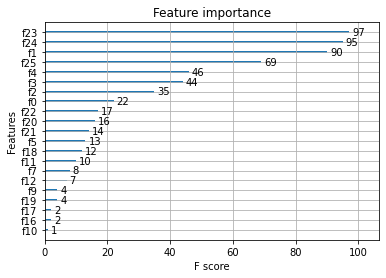

In [31]:
clf = XGBClassifier()
sampler = AllKNN()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_ = scaler.transform(X_train)
X_test_ = scaler.transform(X_test)
        
if sampler:
    X_train_, y_train_ = sampler.fit_resample(X_train_, y_train)

clf.fit(X_train_, y_train_)

y_predict = clf.predict(X_test_)

print("=> f1 score:", f1_score(y_test, y_predict))
print("=> recall:", recall_score(y_test, y_predict))
print("=> precision:", precision_score(y_test, y_predict))
print("=> accuracy:", accuracy_score(y_test, y_predict))

a = xgb.plot_importance(clf)

In [32]:
for i in [23, 24, 1, 25, 4, 3, 2]: 
    print(i, X_df.columns[i]) 

23 Age_Decision
24 Seniority_Decision
1 Net_Annual_Income
25 Closed
4 Nb_Of_Products
3 Years_At_Residence
2 Years_At_Business


The results are better than those obtained during the validation phase. This is due to the fact that this time we have trained the model over the **whole training set**, but also to the fact that the **number of lines is limited** and that the test set may be rather avatageous for our model.

The most important variables are those related to **the seniority** and **the age** of the client: his age at the beginning of the contract, his seniority as a client, his income ...

This is quite **consistent** and we can see why these data are key for this problem.

### Conclusion

We analyzed the dataset in an efficient way in order to be able to understand it and to select the variables allowing us to set up a classifier. We then set up a pipeline to evaluate the sampling methods and model them efficiently. 

If we were to follow up on this project, we would be able to deepen our search for the best model or the best sampling method using the tool we have developed. This could be done depending on what we want to do with this dataset. We could also continue to develop the quantitative analysis of the dataset in order to isolate groups of individuals, for example. 